In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from typing import List

%matplotlib inline

### Анализ данных

Загрузим датасет и проверим его на пропуски в данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Два признака в которых есть пропуски - это Item_Weight и Outlet_Sze, вес товара и размер магазина соответственно.

Пропуски нужно как-то заполнить. Есть предположение, что вес товаров в одной категории должен быть примерно одинаковым. Проверим это предположение.

In [5]:
# всего 16 категорий
df.Item_Type.unique().shape

(16,)

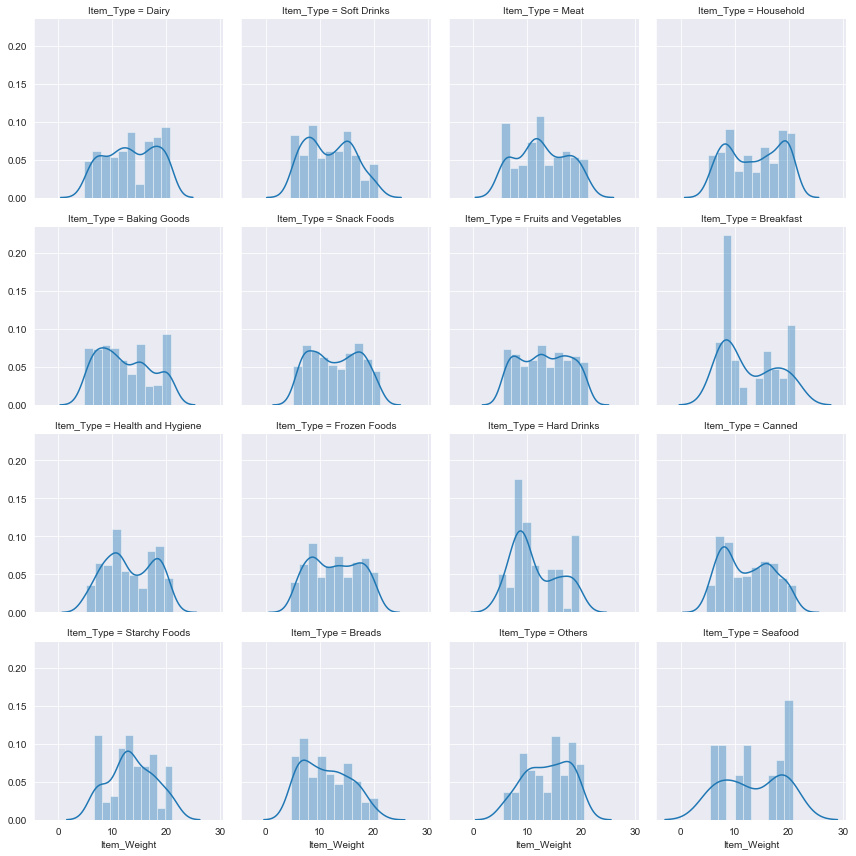

In [6]:
# визуализируем распределние веса товаров с помощью гистограммы
sns.set_style('darkgrid')
df_plot = df.dropna()

g = sns.FacetGrid(df_plot, col='Item_Type', col_wrap=4)
g.map(sns.distplot, 'Item_Weight', bins=10)
plt.show()

На графиках не получилось заметить нормальное распределение веса, для большинства категорий распределние веса товаров скорее равномерное.

В датасете указанны данные о продажах. Один и тот же товар может быть в разных магазинах, проверим сколько в датасете уникальных товаров.

In [7]:
# всего 1559 уникальных товаров
df.Item_Identifier.unique().shape

(1559,)

Если данных о весе товара нет у одного магазина, то это не значит, что их нет у другого магазина. Скорее всего можно будет восстановить данные о весе по данным другого магазина об этом товаре.

In [10]:
df[df['Item_Weight'].isnull()].head(1)

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  \
7           FDP10          NaN          Low Fat          0.12747  Snack Foods   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
7  107.7622            OUT027                       1985      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
7               Tier 3  Supermarket Type3          4022.7636

In [12]:
df[df.Item_Identifier == 'FDP10'].head(3)

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
7              FDP10          NaN          Low Fat         0.127470   
585            FDP10         19.0          Low Fat         0.128066   
2623           FDP10         19.0          Low Fat         0.128815   

        Item_Type  Item_MRP Outlet_Identifier  Outlet_Establishment_Year  \
7     Snack Foods  107.7622            OUT027                       1985   
585   Snack Foods  104.3622            OUT035                       2004   
2623  Snack Foods  107.6622            OUT017                       2007   

     Outlet_Size Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
7         Medium               Tier 3  Supermarket Type3          4022.7636  
585        Small               Tier 2  Supermarket Type1          1905.5196  
2623         NaN               Tier 2  Supermarket Type1          1164.4842

Предположение подтвердилось, данные о весе можно восстановить по данным из других магазинов. 

Теперь напишем функцию, для заполнения пропущенных полей.

In [13]:
def fill_weight(df: DataFrame, category: str) -> List[float]:
    new_weights = []
    for i in df.index:
        if math.isnan(df.loc[i, category]):
            id = df.loc[i, 'Item_Identifier']
            condition = (df['Item_Identifier'] == id) & df[category].notnull()
            try:
                weight = df[condition][category].iloc[0]
            except IndexError:
                weight = df.loc[i, category]
        else:
            weight = df.loc[i, category]
    
        new_weights.append(weight)
    
    return new_weights

In [14]:
new_weights = fill_weight(df, 'Item_Weight')

df['Item_Weight'] = new_weights

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Мы успешно заполнили практически все пропуски.

In [16]:
df[df['Item_Weight'].isnull()]

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
927            FDN52          NaN          Regular         0.130933   
1922           FDK57          NaN          Low Fat         0.079904   
4187           FDE52          NaN          Regular         0.029742   
5022           FDQ60          NaN          Regular         0.191501   

         Item_Type  Item_MRP Outlet_Identifier  Outlet_Establishment_Year  \
927   Frozen Foods   86.9198            OUT027                       1985   
1922   Snack Foods  120.0440            OUT027                       1985   
4187         Dairy   88.9514            OUT027                       1985   
5022  Baking Goods  121.2098            OUT019                       1985   

     Outlet_Size Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
927       Medium               Tier 3  Supermarket Type3          1569.9564  
1922      Medium               Tier 3  Supermarket Type3          4434.2280  
4187      Medium               Tier 3  Supermarket Type3          3453.5046  
5022       Small               Tier 1      Grocery Store           120.5098

In [17]:
df[df.Item_Identifier == 'FDN52'].head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
927           FDN52          NaN          Regular         0.130933   

        Item_Type  Item_MRP Outlet_Identifier  Outlet_Establishment_Year  \
927  Frozen Foods   86.9198            OUT027                       1985   

    Outlet_Size Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
927      Medium               Tier 3  Supermarket Type3          1569.9564

Каждый из оставшихся товаров есть только в одном магазине, поэтому пропуски заполнить не удалось. Можно заолнить пропуск средним значением для категории, но лучше этого не делать, так как это может повлиять на качество модели. Лучше удалить эти 4 строчки из выборки, но перед тем, как это делать, нужно обработать пропуски для колонки Outlet Size.

Для начала, проверим, можно ли восстановить размер магазина по информации из других строк.

In [22]:
df[df['Outlet_Size'].isnull()].head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
3            FDX07       19.200          Regular         0.000000   
8            FDH17       16.200          Regular         0.016687   
9            FDU28       19.200          Regular         0.094450   
25           NCD06       13.000          Low Fat         0.099887   
28           FDE51        5.925          Regular         0.161467   

                Item_Type  Item_MRP Outlet_Identifier  \
3   Fruits and Vegetables  182.0950            OUT010   
8            Frozen Foods   96.9726            OUT045   
9            Frozen Foods  187.8214            OUT017   
25              Household   45.9060            OUT017   
28                  Dairy   45.5086            OUT010   

    Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
3                        1998         NaN               Tier 3   
8                        2002         NaN               Tier 2   
9                        2007         NaN               Tier 2   
25                       2007         NaN               Tier 2   
28                       1998         NaN               Tier 3   

          Outlet_Type  Item_Outlet_Sales  
3       Grocery Store           732.3800  
8   Supermarket Type1          1076.5986  
9   Supermarket Type1          4710.5350  
25  Supermarket Type1           838.9080  
28      Grocery Store           178.4344

In [23]:
cond = (df.Outlet_Identifier == 'OUT010') & df.Outlet_Size.notnull() 
df[cond].head()

Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales]
Index: []

Информация о размере магазина отсутсвует для всех идентификаторов этого магазина. Каждый магазин расположен в определенно категории города и у каждого магазина есть свой тип. Попробуем сгруппировать размер магазина по этим признакам. 

In [50]:
print('Все уникальные Outlet_Location_Type:', df.Outlet_Location_Type.unique())

Все уникальные Outlet_Location_Type: ['Tier 1' 'Tier 3' 'Tier 2']


In [51]:
print('Все уникальные Outlet_Type:', df.Outlet_Type.unique())

Все уникальные Outlet_Type: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [32]:
df.groupby(['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']).count()

Item_Identifier  \
Outlet_Location_Type Outlet_Type       Outlet_Size                    
Tier 1               Grocery Store     Small                    528   
                     Supermarket Type1 Medium                   930   
                                       Small                    930   
Tier 2               Supermarket Type1 Small                    930   
Tier 3               Supermarket Type1 High                     932   
                     Supermarket Type2 Medium                   928   
                     Supermarket Type3 Medium                   935   

                                                    Item_Weight  \
Outlet_Location_Type Outlet_Type       Outlet_Size                
Tier 1               Grocery Store     Small                527   
                     Supermarket Type1 Medium               930   
                                       Small                930   
Tier 2               Supermarket Type1 Small                930   
Tier 3               Supermarket Type1 High                 932   
                     Supermarket Type2 Medium               928   
                     Supermarket Type3 Medium               932   

                                                    Item_Fat_Content  \
Outlet_Location_Type Outlet_Type       Outlet_Size                     
Tier 1               Grocery Store     Small                     528   
                     Supermarket Type1 Medium                    930   
                                       Small                     930   
Tier 2               Supermarket Type1 Small                     930   
Tier 3               Supermarket Type1 High                      932   
                     Supermarket Type2 Medium                    928   
                     Supermarket Type3 Medium                    935   

                                                    Item_Visibility  \
Outlet_Location_Type Outlet_Type       Outlet_Size                    
Tier 1               Grocery Store     Small                    528   
                     Supermarket Type1 Medium                   930   
                                       Small                    930   
Tier 2               Supermarket Type1 Small                    930   
Tier 3               Supermarket Type1 High                     932   
                     Supermarket Type2 Medium                   928   
                     Supermarket Type3 Medium                   935   

                                                    Item_Type  Item_MRP  \
Outlet_Location_Type Outlet_Type       Outlet_Size                        
Tier 1               Grocery Store     Small              528       528   
                     Supermarket Type1 Medium             930       930   
                                       Small              930       930   
Tier 2               Supermarket Type1 Small              930       930   
Tier 3               Supermarket Type1 High               932       932   
                     Supermarket Type2 Medium             928       928   
                     Supermarket Type3 Medium             935       935   

                                                    Outlet_Identifier  \
Outlet_Location_Type Outlet_Type       Outlet_Size                      
Tier 1               Grocery Store     Small                      528   
                     Supermarket Type1 Medium                     930   
                                       Small                      930   
Tier 2               Supermarket Type1 Small                      930   
Tier 3               Supermarket Type1 High                       932   
                     Supermarket Type2 Medium                     928   
                     Supermarket Type3 Medium                     935   

                                                    Outlet_Establishment_Year  \
Outlet_Location_Type Outlet_Type       Outlet_Size                              
Tier 1               Gr

Из этой группировки, можно сделать выводы о том, каким скорее всего должен быть размер магазина в зависимости от категории города и типа магазина.

Для каждого города и типа магазина, есть свой размер. Исключением является город Tier 1 и магазин Supermarket Type 1, это комбинция может означать, как средний, так и большой магазин. Чтобы понять, насколько это критично для заполнения пропусков, посмотрим для скольки магазинов с такой комбинацией город/тип магазина отсутсвует размер.

In [38]:
cond = (df.Outlet_Location_Type == 'Tier 1') & (df.Outlet_Type == 'Supermarket Type1') & df.Outlet_Size.isnull()
df[cond]

Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales]
Index: []

Нам повезло и в датасете нет магазинов с отсутствующим размером для данной комбинации город/тип магазина.

Теперь напишем функцию, которая заполнит пропуски в Outlet_Size.

In [43]:
def fill_size(df: DataFrame) -> List[str]:
    new_sizes = []
    for i in df.index:
        if df.loc[i, 'Outlet_Location_Type'] == 'Tier 1' and df.loc[i, 'Outlet_Type'] == 'Grocery Store':
            size = 'Small'
        elif df.loc[i, 'Outlet_Location_Type'] == 'Tier 2' and df.loc[i, 'Outlet_Type'] == 'Supermarket Type1':
            size = 'Small'
        elif df.loc[i, 'Outlet_Location_Type'] == 'Tier 3':
            if df.loc[i, 'Outlet_Type'] == 'Supermarket Type1':
                size = 'High'
            elif df.loc[i, 'Outlet_Type'] == 'Supermarket Type2':
                size = 'Medium'
            elif df.loc[i, 'Outlet_Type'] == 'Supermarket Type3':
                size = 'Medium'
        else:
            size = df.loc[i, 'Outlet_Size']
    
        new_sizes.append(size)
    
    return new_sizes

In [44]:
new_sizes = fill_size(df)

df['Outlet_Size'] = new_sizes

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Все данные Outlet_Size заполнены, теперь осталось только удалить 4 строки, в которых отсутствуют данные о весе.

In [54]:
df.dropna(inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8519 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8519 non-null object
Item_Visibility              8519 non-null float64
Item_Type                    8519 non-null object
Item_MRP                     8519 non-null float64
Outlet_Identifier            8519 non-null object
Outlet_Establishment_Year    8519 non-null int64
Outlet_Size                  8519 non-null object
Outlet_Location_Type         8519 non-null object
Outlet_Type                  8519 non-null object
Item_Outlet_Sales            8519 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB
